# **6. 나를 찾아줘 - Class Activation Map 만들기**

# **6-1. 들어가며**

<br>

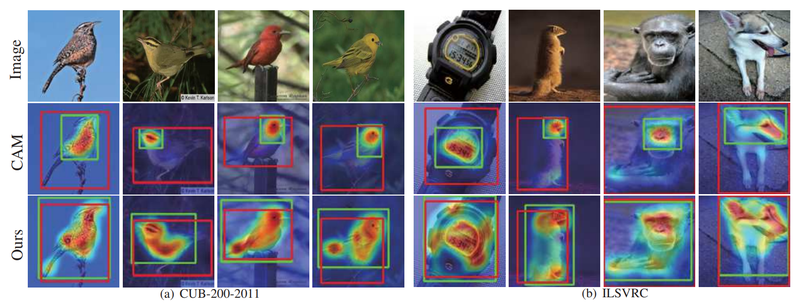

<br>

이번 시간에는 CAM(Class Activation Map)을 얻기 위한 방법 중 기본 `CAM`과 `Grad-CAM`을 구현해보고 이를 시각화해 보겠습니다. 그리고 CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교해 보겠습니다.

### **실습목표**

---

- Classification model로부터 CAM을 얻어낼 수 있다.
- CAM으로 물체의 위치를 찾을 수 있다.
- CAM을 시각화 비교할 수 있다.

### **학습 내용**

---

- CAM, Grad-CAM용 모델 준비하기
- CAM
- Grad-CAMDetection with CAM

### **준비물**

---

터미널을 열고 프로젝트를 위한 디렉토리를 생성해 주세요.

```python
$ mkdir -p ~/aiffel/class_activation_map/data
$ ln -s ~/data/* ~/aiffel/class_activation_map/data
```

# **6-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기**

**CAM(Class Activation Map)**은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있습니다. 반면에 Grad-CAM은 이러한 제약이 없죠.

<br>

이번 시간에는 CAM과 Grad-CAM, 이 두 가지를 모두 구현해 보겠습니다.우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

<br>

CAM은 **클래스에 대한 활성화 정도를 나타낸 지도**입니다. 따라서 기본적으로 우리의 모델은 **분류(classfication)**를 수행하는 모델이어야 합니다. 하지만 **우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것**이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

<br>

`Tensorflow Datasets`의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 여기서는 `stanford_dogs` 데이터셋을 사용하겠습니다. 이는 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 **바운딩 박스(bounding box)** 정보를 포함하고 있습니다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.

- [stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)

In [55]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [56]:
tf.config.list_physical_devices('GPU') # [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

`stanford_dogs` 데이터셋은 12,000장의 학습용 데이터셋과 8,580장의 평가용 데이터셋으로 구성되어있습니다. `tfds.load()`를 활용해서 데이터셋을 다운로드 해주세요.

In [57]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


`tfds.show_examples()` 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있습니다.

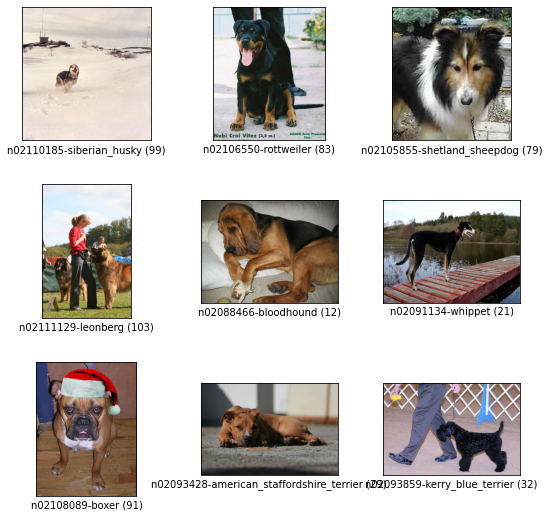

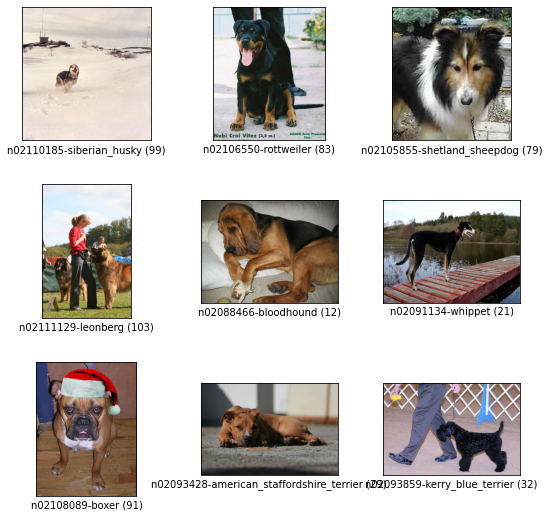

In [58]:
tfds.show_examples(ds_train, ds_info)

학습용 데이터셋 뿐만 아니라 평가용 데이터셋도 눈으로 확인해 보세요.

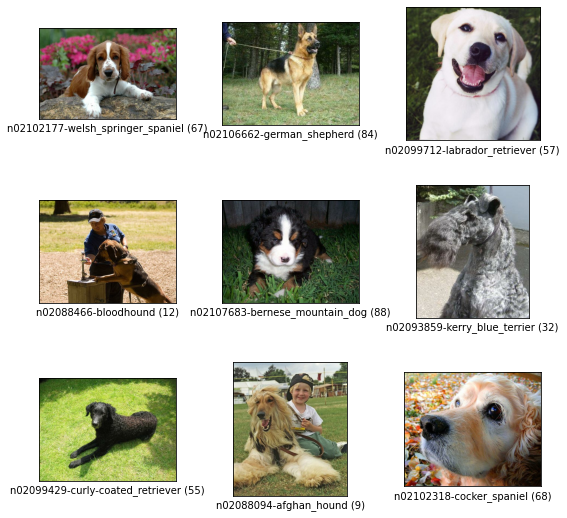

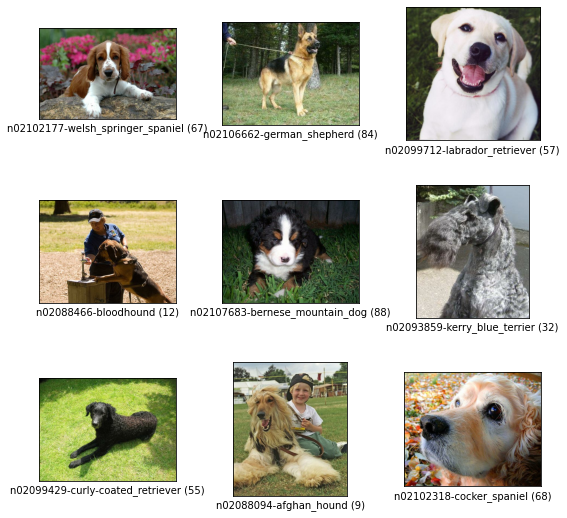

In [59]:
tfds.show_examples(ds_test, ds_info)

# **6-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보**

원본 이미지 위에 물체의 위치정보는 어떻게 시각화하여 표시할 수 있을까요? 데이터셋의 메타 정보인 `df_info`를 조회해 `features`가 어떻게 구성되어 있는지 확인해 봅시다.

In [60]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

먼저 `image`와 `label`은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스입니다. 몇 번 보신 적 있으신가요? 그런데 조금 새로운 키(key)가 있습니다. `bbox`는 무엇일까요? `bbox`(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 `BBoxFeature`이라는 타입으로 정의되어 있습니다.

<br>

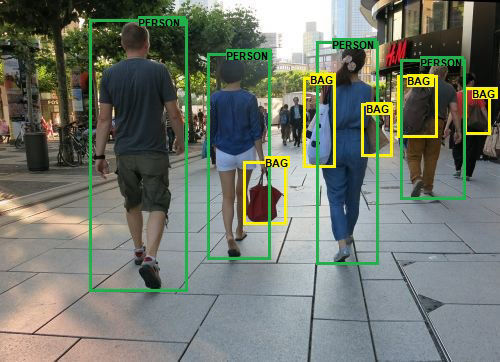

### **바운딩 박스를 표시하는 방법들**

---

바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.

- 'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.
    - (예) `(x_center, y_center, width, height)`
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.
- 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.
    - (예) `(x_min, x_max, y_min, y_max)`
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.

<br>

위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있습니다. 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋습니다.

- [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)

<br>

<aside>
💡 Q1. 주어진 데이터셋에서 `BBoxFeature` 타입으로 표기된 `bbox` 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있나요? 위에 제시된 텐서플로우 튜토리얼 링크를 통해 확인해 봅시다.

---

해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다

</aside>

# **6-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기**

이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠습니다. 미리 이미지넷(ImageNet) 데이터에 훈련된 `ResNet50`을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.

### **구현해 보기**

아래에서 직접 `ResNet50` 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해 주세요. CAM 모델의 구조가 생각나지 않는다면, Lecture 노드나 관련 내용을 참고해 완성해 보세요.

In [61]:
num_classes = ds_info.features["label"].num_classes # class의 개수
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

cam_model = keras.Model(inputs=base_model.input, outputs=preds)

CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없습니다. 다만 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다. 우리의 경우 `ResNet50`의 매개변수 `pooling`에 `'avg'`를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.

- [tf.keras.applications.resnet50.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

<br>

아래에서 직접 만든 CAM모델을 확인해 주세요.

In [62]:
cam_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

<aside>
💡 Q2. CAM은 특성 맵(feature map)을 사용해 만듭니다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까요? 해당 레이어의 이름을 찾아보세요.

---

conv5_block3_out의 output이 feature map이 됩니다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 됩니다.

</aside>

# **6-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기**

이제 학습을 위한 과정은 이전과 비슷합니다.

<br>

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 `normalize_and_resize_img()` 에서 수행하며, 이를 포함하여 `apply_normalize_on_dataset()`에서 배치를 구성합니다.

<br>

`input`에 이전과 다르게 `bbox` 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 `normalize_and_resize_img`과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [63]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

print('슝=3')

슝=3


In [64]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [65]:
ds_train

<_OptionsDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)}}>

In [66]:
ds_test

<_OptionsDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)}}>

In [68]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape) #(16, 224, 224, 3)
    print(label.shape) #(16,)

(16, 224, 224, 3)
(16,)


이제 모델을 컴파일하고 학습시킵시다. 여기서는 맛보기로 2 Epoch 만 학습시켜 봅시다.😊 (뒷 부분에서는 미리 준비해둔 학습된 가중치를 불러와서 모델에 적용할 예정입니다.)

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 183s 218ms/step - loss: 2.2129 - accuracy: 0.4462 - val_loss: 3.6466 - val_accuracy: 0.1651
Epoch 2/2
750/750 [==============================] - 161s 215ms/step - loss: 0.6819 - accuracy: 0.8092 - val_loss: 1.1856 - val_accuracy: 0.6558


학습시킨 가중치를 저장해 주겠습니다. (아래 코드의 주석을 풀면 직접 학습시킨 가중치를 저장할 수 있습니다.)

In [ ]:
import os

cam_model_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

print("저장 완료!")

저장 완료!


# **6-6. CAM**

> 이제 학습된 모델을 활용하여 CAM을 생성해 볼 것입니다. 메모리 부족으로 인해 이후 실습에 문제가 발생할 수 있으므로, 이번 스텝 시작 전에 커널을 재시작할 것을 권합니다.
>

In [ ]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


이제 학습된 모델에서 CAM을 생성해 봅시다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


67


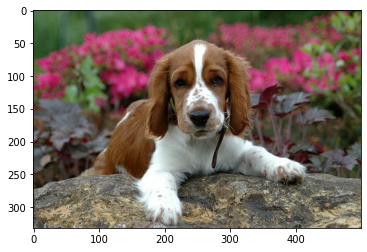

In [ ]:
item = get_one(ds_test)

print(item['label'])
plt.imshow(item['image'])
plt.show()

이제 데이터가 준비되었으니 CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러와 봅시다.

In [ ]:
import os

cam_model_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

print('슝=3')

슝=3


CAM을 생성하기 위해서는 
* **(1) 특성 맵**
* **(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치**
* **(3) 원하는 클래스의 출력값이 필요합니다.**

또 **이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면** 네트워크에서 나온 **CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것**입니다. 이를 고려해서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

<br>

`generate_cam()` 을 구현하기 위해 아래에서는 `conv_ouputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize`해 주었습니다.

In [ ]:
item['image'].shape

(332, 500, 3)

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)      # item deepcopy
    width = item['image'].shape[1]  # 너비
    height = item['image'].shape[0] # 높이
    
    # output : item['image'], item['label']
    img_tensor, class_idx = normalize_and_resize_img(item) # image resize 및 normalize
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


이제 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있습니다. 생각보다 위치를 정확하게 표현하고 있습니다.

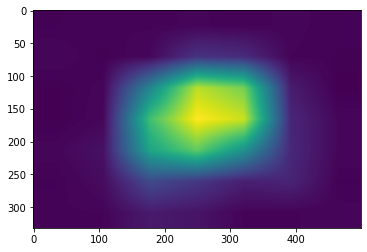

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이렇게 그려진 CAM 이미지를 원본 이미지와 합쳐 봅시다.

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.3):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


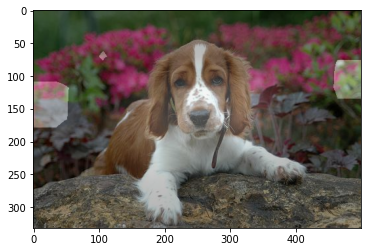

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

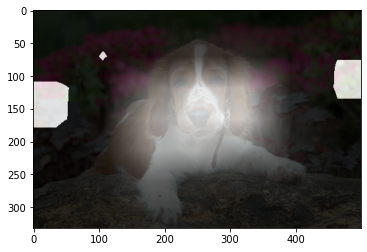

In [ ]:
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.8)
plt.imshow(blended_image)
plt.show()

어떤가요? 생성된 CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있나요? 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있는데, 이것은 사람이 개를 식별할 때 유의해서 보는 부분과 일맥상통합니다.

# **6-7. Grad-CAM**

이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 `cam_model`을 그대로 활용합시다.

<br>

우선 새로운 이미지를 뽑아봅시다.

67


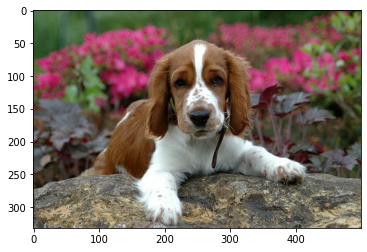

In [ ]:
item = get_one(ds_test)

print(item['label'])
plt.imshow(item['image'])
plt.show()

이번에는 Grad-CAM을 이용해서 CAM을 만들어 봅시다.

<br>

`grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weights`)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻게 됩니다.

<br>

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 합니다.

<br>

아래 `generate_grad_cam()`에서는 원하는 레이어의 `output`과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 `weights`로 활용합니다.

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 이전 스탭의 `cam_model.summary()` 결과에서 찾을 수 있습니다.

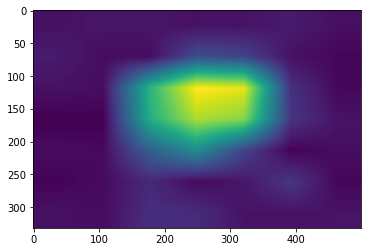

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

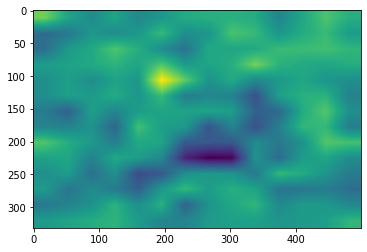

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

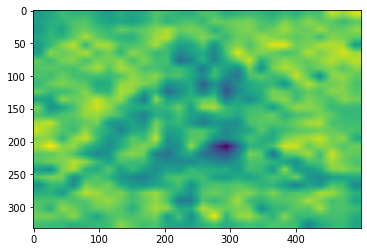

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# **6-8. Detection with CAM**

### **바운딩 박스**

---

마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아봅시다.

40


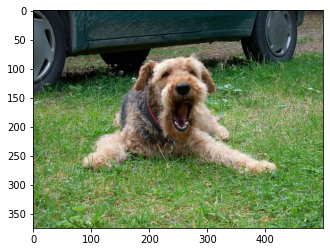

In [30]:
item = get_one(ds_test)

print(item['label'])
plt.imshow(item['image'])
plt.show()

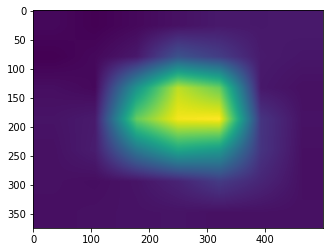

In [31]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스텝에서 만들었던 `generate_cam()`을 활용해서 CAM 이미지를 뽑았습니다. 아래 `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾습니다. 이때 `rotated_rect` 라는 회전된 바운딩 박스를 얻을 수 있습니다. `boxPoints()`로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 `int` 자료형으로 변환해 줍니다.

In [46]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [47]:
rect = get_bbox(cam_image)
rect

array([[109, 327],
       [109,  39],
       [432,  39],
       [432, 327]])

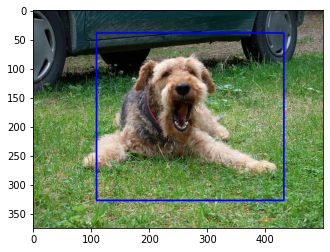

In [48]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### **Intersection Over Union**

---

위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻을 수 있었습니다. 그럼 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까요?

<br>

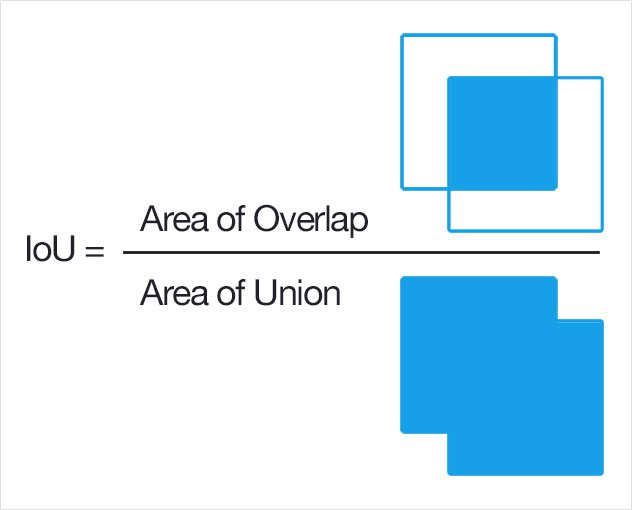

<br>

**IoU(Intersection over Union)**는 두 영역의 교집합인 **intersection** 영역의 넓이를 두 영역의 합집합인 **union 영역**으로 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

<br>

자세한 내용이 궁금하시다면 아래 영상을 참조하세요.

- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE)

In [35]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


위에서 구했던 `rect`를 minmax `bbox` 형태로 치환해 봅시다.

In [36]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.104, 0.218, 0.872, 0.864]

이 데이터의 ground truth bbox를 확인해 봅시다.

In [37]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

어떤가요? CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌나요? 이 둘이 얼마나 유사한지를 IoU를 계산해서 확인해 봅시다.

In [38]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [52]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6713845016786463

# **6-9. 프로젝트: CAM을 만들고 평가해 보자**